# 🚀 YOLO v11 Training - Industrial Product Detection

Notebook này được thiết kế để chạy trên **Google Colab** với GPU.

## Nội dung:
1. Cài đặt môi trường
2. Upload và chuẩn bị dataset
3. Train YOLOv11n (Nano)
4. Train YOLOv11s (Small)
5. So sánh hiệu suất giữa 2 phiên bản

---

## 1. Kiểm tra GPU và Cài đặt Ultralytics

In [1]:
# Kiểm tra GPU
!nvidia-smi

Mon Dec  1 04:59:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Cài đặt ultralytics (YOLO v11)
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.1 MB/s eta 0:00:00


In [3]:
# Import các thư viện cần thiết
from ultralytics import YOLO
import torch
import os
from google.colab import drive

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


## 2. Upload Dataset

### Cách 1: Upload trực tiếp từ máy tính (Khuyến nghị cho dataset nhỏ)
Upload file zip `industrial_product_dataset.zip` lên Colab

### Cách 2: Upload lên Google Drive rồi mount (Khuyến nghị cho dataset lớn)

In [4]:
# ===== CÁCH 1: Upload trực tiếp =====
from google.colab import files

# Upload file zip dataset
print("Hãy upload file 'industrial_product_dataset.zip'")
uploaded = files.upload()

Hãy upload file 'industrial_product_dataset.zip'


KeyboardInterrupt: 

In [ ]:
# Giải nén dataset
!unzip -q industrial_product_dataset.zip -d /content/

# Đường dẫn đến dataset
DATASET_PATH = "/content/industrial_product_dataset"
DATA_YAML = f"{DATASET_PATH}/data.yaml"

print(f"Dataset path: {DATASET_PATH}")
print(f"Data YAML: {DATA_YAML}")

In [5]:
# ===== CÁCH 2: Mount Google Drive (Bỏ qua nếu dùng Cách 1) =====
drive.mount('/content/drive')

# Nếu dataset nằm trong Drive, copy vào /content để train nhanh hơn
!cp -r "/content/drive/MyDrive/industrial_product_dataset" /content/

DATASET_PATH = "/content/industrial_product_dataset"
DATA_YAML = f"{DATASET_PATH}/data.yaml"

Mounted at /content/drive


In [6]:
# Kiểm tra cấu trúc dataset
print("📁 Cấu trúc dataset:")
!ls -la {DATASET_PATH}

print("\n📁 Images - Train:")
!ls {DATASET_PATH}/images/train | head -10

print("\n📁 Images - Val:")
!ls {DATASET_PATH}/images/val | head -10

print("\n📁 Labels - Train:")
!ls {DATASET_PATH}/labels/train | head -10

# Đếm số lượng ảnh
train_images = len(os.listdir(f"{DATASET_PATH}/images/train"))
val_images = len(os.listdir(f"{DATASET_PATH}/images/val"))
print(f"\n📊 Tổng số ảnh train: {train_images}")
print(f"📊 Tổng số ảnh val: {val_images}")

📁 Cấu trúc dataset:
total 20
drwx------ 4 root root 4096 Dec  1 05:03 .
drwxr-xr-x 1 root root 4096 Dec  1 05:03 ..
-rw------- 1 root root  216 Dec  1 05:03 data.yaml
drwx------ 4 root root 4096 Dec  1 05:03 images
drwx------ 4 root root 4096 Dec  1 05:03 labels

📁 Images - Train:
00000.jpg
00001.jpg
00002.jpg
00003.jpg
00004.jpg
00005.jpg
00006.jpg
00007.jpg
00008.jpg
00009.jpg

📁 Images - Val:
00260.jpg
00261.jpg
00262.jpg
00263.jpg
00264.jpg
00265.jpg
00266.jpg
00267.jpg
00268.jpg
00269.jpg

📁 Labels - Train:
00000.txt
00001.txt
00002.txt
00003.txt
00004.txt
00005.txt
00006.txt
00007.txt
00008.txt
00009.txt

📊 Tổng số ảnh train: 260
📊 Tổng số ảnh val: 66


In [8]:
# Xem nội dung file data.yaml
print("📄 Nội dung data.yaml:")
!cat {DATA_YAML}

📄 Nội dung data.yaml:
# Industrial Product Detection Dataset
# Generated by SAM 2 Object Tracking Notebook

path: /content/industrial_product_dataset
train: images/train
val: images/val

# Classes
names:
  0: product

# Number of classes
nc: 1


## 3. Cấu hình Training Parameters

In [9]:
# ============================================
# TRAINING CONFIGURATION
# ============================================

# Các tham số training chung cho cả 2 model
EPOCHS = 100           # Số epochs (tăng lên nếu cần)
BATCH_SIZE = 16        # Batch size (giảm xuống nếu hết VRAM)
IMG_SIZE = 640         # Kích thước ảnh
PATIENCE = 20          # Early stopping patience
WORKERS = 2            # Số workers cho dataloader

# Tên project để lưu kết quả
PROJECT_NAME = "yolo_industrial_product"

print("✅ Training configuration loaded")
print(f"   - Epochs: {EPOCHS}")
print(f"   - Batch size: {BATCH_SIZE}")
print(f"   - Image size: {IMG_SIZE}")
print(f"   - Early stopping patience: {PATIENCE}")

✅ Training configuration loaded
   - Epochs: 100
   - Batch size: 16
   - Image size: 640
   - Early stopping patience: 20


## 4. Train YOLOv11n (Nano)

YOLOv11n là phiên bản nhỏ nhất, nhanh nhất nhưng độ chính xác thấp hơn.
- **Parameters**: ~2.6M
- **FLOPs**: ~6.5G
- **Tốc độ inference**: Nhanh nhất

In [10]:
# Load YOLOv11n pretrained model
model_nano = YOLO('yolo11n.pt')

print("📥 YOLOv11n model loaded successfully")
print(f"   Model info: {model_nano.info()}")

📥 YOLOv11n model loaded successfully
YOLO11n summary: 181 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs
   Model info: (181, 2624080, 0, 6.614336)


In [11]:
# Train YOLOv11n
results_nano = model_nano.train(
    data=DATA_YAML,
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    imgsz=IMG_SIZE,
    patience=PATIENCE,
    workers=WORKERS,
    project=PROJECT_NAME,
    name="yolov11n",
    exist_ok=True,
    pretrained=True,
    optimizer='auto',
    verbose=True,
    seed=42,
    deterministic=True,
    plots=True,
    save=True,
    save_period=10,  # Save checkpoint every 10 epochs
)

print("\n✅ YOLOv11n training completed!")

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/industrial_product_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0,

In [12]:
# Validate YOLOv11n
metrics_nano = model_nano.val()

print("\n📊 YOLOv11n Validation Results:")
print(f"   mAP50: {metrics_nano.box.map50:.4f}")
print(f"   mAP50-95: {metrics_nano.box.map:.4f}")
print(f"   Precision: {metrics_nano.box.mp:.4f}")
print(f"   Recall: {metrics_nano.box.mr:.4f}")

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2210.7±646.6 MB/s, size: 135.9 KB)
val: Scanning /content/industrial_product_dataset/labels/val.cache... 66 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 66/66 129.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 2.6it/s 1.9s
                   all         66        170      0.933      0.965      0.989      0.953
Speed: 5.5ms preprocess, 6.8ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to /content/runs/detect/val

📊 YOLOv11n Validation Results:
   mAP50: 0.9888
   mAP50-95: 0.9527
   Precision: 0.9331
   Recall: 0.9647


## 5. Train YOLOv11s (Small)

YOLOv11s là phiên bản cân bằng giữa tốc độ và độ chính xác.
- **Parameters**: ~9.4M
- **FLOPs**: ~21.5G
- **Tốc độ inference**: Nhanh, độ chính xác cao hơn Nano

In [13]:
# Load YOLOv11s pretrained model
model_small = YOLO('yolo11s.pt')

print("📥 YOLOv11s model loaded successfully")
print(f"   Model info: {model_small.info()}")

📥 YOLOv11s model loaded successfully
YOLO11s summary: 181 layers, 9,458,752 parameters, 0 gradients, 21.7 GFLOPs
   Model info: (181, 9458752, 0, 21.718374400000002)


In [14]:
# Train YOLOv11s
results_small = model_small.train(
    data=DATA_YAML,
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    imgsz=IMG_SIZE,
    patience=PATIENCE,
    workers=WORKERS,
    project=PROJECT_NAME,
    name="yolov11s",
    exist_ok=True,
    pretrained=True,
    optimizer='auto',
    verbose=True,
    seed=42,
    deterministic=True,
    plots=True,
    save=True,
    save_period=10,  # Save checkpoint every 10 epochs
)

print("\n✅ YOLOv11s training completed!")

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/industrial_product_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0,

In [15]:
# Validate YOLOv11s
metrics_small = model_small.val()

print("\n📊 YOLOv11s Validation Results:")
print(f"   mAP50: {metrics_small.box.map50:.4f}")
print(f"   mAP50-95: {metrics_small.box.map:.4f}")
print(f"   Precision: {metrics_small.box.mp:.4f}")
print(f"   Recall: {metrics_small.box.mr:.4f}")

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2209.2±422.9 MB/s, size: 135.9 KB)
val: Scanning /content/industrial_product_dataset/labels/val.cache... 66 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 66/66 134.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 1.6it/s 3.1s
                   all         66        170       0.96      0.953      0.982       0.95
Speed: 6.2ms preprocess, 8.9ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to /content/runs/detect/val2

📊 YOLOv11s Validation Results:
   mAP50: 0.9816
   mAP50-95: 0.9501
   Precision: 0.9605
   Recall: 0.9529


## 6. So sánh Hiệu suất giữa YOLOv11n và YOLOv11s

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# Đường dẫn đến các folder validation results
VAL_NANO_PATH = "/content/runs/detect/val"
VAL_SMALL_PATH = "/content/runs/detect/val2"

# Đọc results.json từ các folder
try:
    with open(f'{VAL_NANO_PATH}/results.json', 'r') as f:
        nano_results = json.load(f)

    with open(f'{VAL_SMALL_PATH}/results.json', 'r') as f:
        small_results = json.load(f)

    # Tạo bảng so sánh từ results.json
    comparison_data = {
        'Model': ['YOLOv11n', 'YOLOv11s'],
        'mAP50': [nano_results.get('metrics/mAP50(B)', 'N/A'), small_results.get('metrics/mAP50(B)', 'N/A')],
        'mAP50-95': [nano_results.get('metrics/mAP(B)', 'N/A'), small_results.get('metrics/mAP(B)', 'N/A')],
        'Precision': [nano_results.get('metrics/precision(B)', 'N/A'), small_results.get('metrics/precision(B)', 'N/A')],
        'Recall': [nano_results.get('metrics/recall(B)', 'N/A'), small_results.get('metrics/recall(B)', 'N/A')],
    }
except Exception as e:
    print(f"⚠️ Lỗi đọc results.json: {e}")
    # Fallback: Sử dụng metrics từ validation
    comparison_data = {
        'Model': ['YOLOv11n', 'YOLOv11s'],
        'mAP50': [metrics_nano.box.map50, metrics_small.box.map50],
        'mAP50-95': [metrics_nano.box.map, metrics_small.box.map],
        'Precision': [metrics_nano.box.mp, metrics_small.box.mp],
        'Recall': [metrics_nano.box.mr, metrics_small.box.mr],
    }

df_comparison = pd.DataFrame(comparison_data)

print("=" * 60)
print("📊 BẢNG SO SÁNH HIỆU SUẤT")
print("=" * 60)
print(df_comparison.to_string(index=False))
print("=" * 60)

⚠️ Lỗi đọc results.json: [Errno 2] No such file or directory: '/content/runs/detect/val/results.json'
📊 BẢNG SO SÁNH HIỆU SUẤT
   Model    mAP50  mAP50-95  Precision   Recall
YOLOv11n 0.988794  0.952663   0.933126 0.964706
YOLOv11s 0.981552  0.950071   0.960451 0.952941


/tmp/ipython-input-1108231096.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1108231096.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{PROJECT_NAME}/confusion_matrix_comparison.png', dpi=150, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


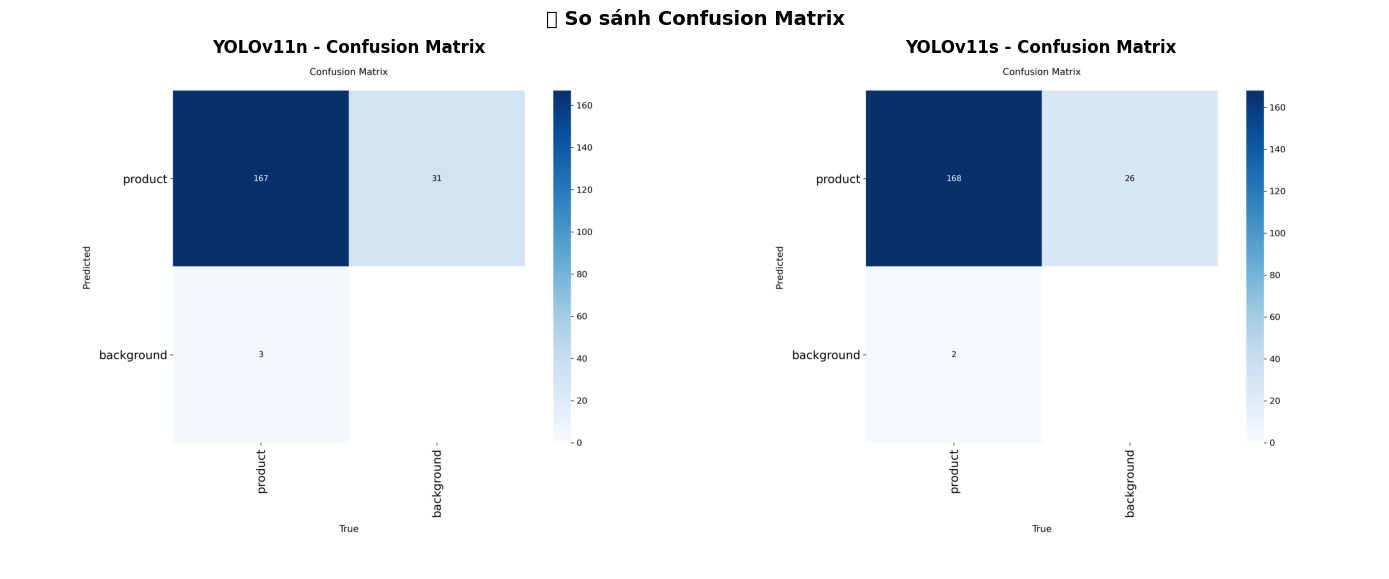

✅ Confusion matrix comparison saved


/tmp/ipython-input-1108231096.py:44: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1108231096.py:45: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{PROJECT_NAME}/pr_curve_comparison.png', dpi=150, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


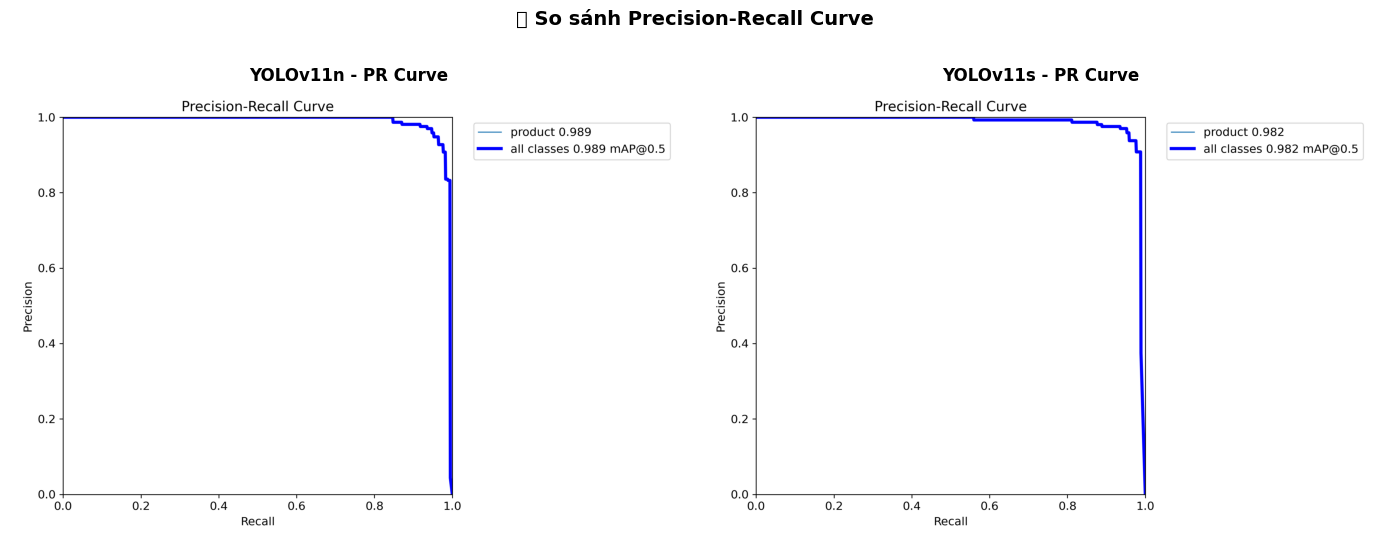

✅ PR curve comparison saved


/tmp/ipython-input-1108231096.py:68: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1108231096.py:69: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{PROJECT_NAME}/f1_curve_comparison.png', dpi=150, bbox_inches='tight')


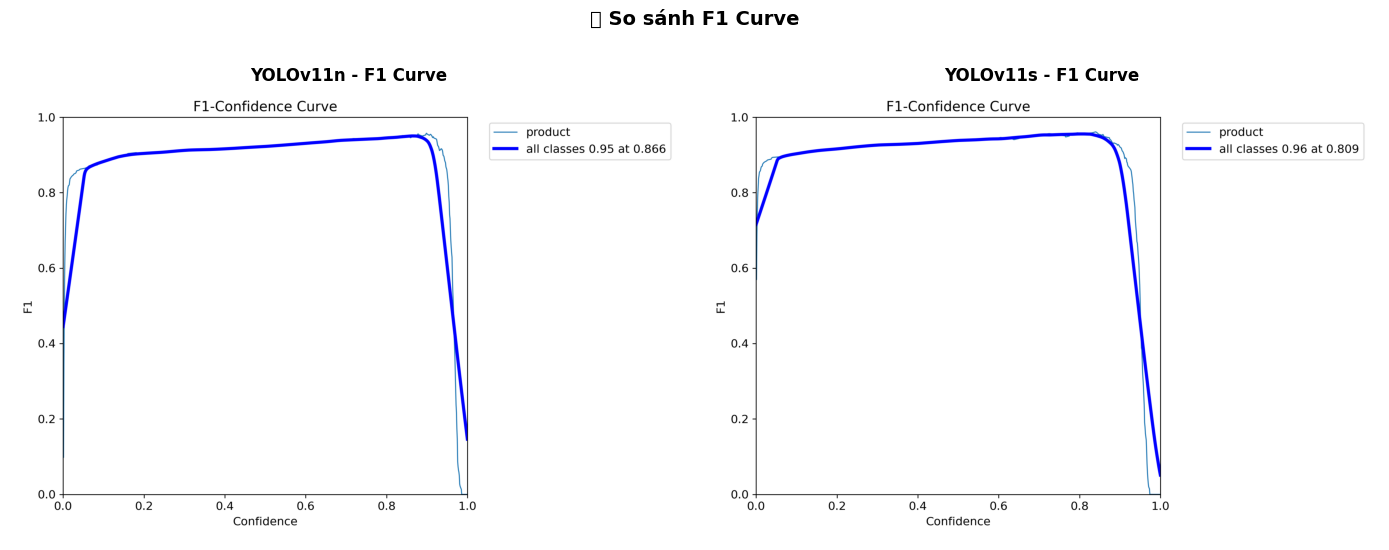

✅ F1 curve comparison saved


In [27]:
# Hiển thị confusion matrix từ validation results
from PIL import Image

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

try:
    # Confusion matrix cho YOLOv11n
    nano_cm = Image.open(f'{VAL_NANO_PATH}/confusion_matrix.png')
    axes[0].imshow(nano_cm)
    axes[0].set_title('YOLOv11n - Confusion Matrix', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # Confusion matrix cho YOLOv11s
    small_cm = Image.open(f'{VAL_SMALL_PATH}/confusion_matrix.png')
    axes[1].imshow(small_cm)
    axes[1].set_title('YOLOv11s - Confusion Matrix', fontsize=12, fontweight='bold')
    axes[1].axis('off')

    plt.suptitle('📊 So sánh Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{PROJECT_NAME}/confusion_matrix_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Confusion matrix comparison saved")
except Exception as e:
    print(f"⚠️ Không thể load confusion matrix: {e}")

# Hiển thị PR curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

try:
    # PR curve cho YOLOv11n
    nano_pr = Image.open(f'{VAL_NANO_PATH}/BoxPR_curve.png')
    axes[0].imshow(nano_pr)
    axes[0].set_title('YOLOv11n - PR Curve', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # PR curve cho YOLOv11s
    small_pr = Image.open(f'{VAL_SMALL_PATH}/BoxPR_curve.png')
    axes[1].imshow(small_pr)
    axes[1].set_title('YOLOv11s - PR Curve', fontsize=12, fontweight='bold')
    axes[1].axis('off')

    plt.suptitle('📈 So sánh Precision-Recall Curve', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{PROJECT_NAME}/pr_curve_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ PR curve comparison saved")
except Exception as e:
    print(f"⚠️ Không thể load PR curve: {e}")

# Hiển thị F1 curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

try:
    # F1 curve cho YOLOv11n
    nano_f1 = Image.open(f'{VAL_NANO_PATH}/BoxF1_curve.png')
    axes[0].imshow(nano_f1)
    axes[0].set_title('YOLOv11n - F1 Curve', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # F1 curve cho YOLOv11s
    small_f1 = Image.open(f'{VAL_SMALL_PATH}/BoxF1_curve.png')
    axes[1].imshow(small_f1)
    axes[1].set_title('YOLOv11s - F1 Curve', fontsize=12, fontweight='bold')
    axes[1].axis('off')

    plt.suptitle('📈 So sánh F1 Curve', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{PROJECT_NAME}/f1_curve_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ F1 curve comparison saved")
except Exception as e:
    print(f"⚠️ Không thể load F1 curve: {e}")

In [28]:
# Tính toán tốc độ inference từ validation results
import time

# Load best models
best_nano = YOLO(f'{PROJECT_NAME}/yolov11n/weights/best.pt')
best_small = YOLO(f'{PROJECT_NAME}/yolov11s/weights/best.pt')

# Lấy một ảnh test
test_images = os.listdir(f"{DATASET_PATH}/images/val")
test_image_path = f"{DATASET_PATH}/images/val/{test_images[0]}"

# Benchmark inference speed (lấy từ results hoặc tính nếu không có)
def benchmark_inference(model, image_path, num_runs=50):
    """Đo tốc độ inference"""
    # Warmup
    for _ in range(5):
        model(image_path, verbose=False)

    # Benchmark
    times = []
    for _ in range(num_runs):
        start = time.time()
        model(image_path, verbose=False)
        times.append((time.time() - start) * 1000)  # Convert to ms

    return sum(times) / len(times)

# Thử lấy speed từ results.json trước
try:
    nano_speed = nano_results.get('inference/ms/image', None)
    small_speed = small_results.get('inference/ms/image', None)

    if nano_speed is None or small_speed is None:
        raise ValueError("Không tìm thấy inference speed trong results.json")
except:
    # Nếu không có, tính bằng benchmark
    print("Đang benchmark tốc độ inference...")
    nano_speed = benchmark_inference(best_nano, test_image_path)
    small_speed = benchmark_inference(best_small, test_image_path)

print("=" * 60)
print("⚡ SO SÁNH TỐC ĐỘ INFERENCE")
print("=" * 60)
print(f"YOLOv11n: {nano_speed:.2f} ms/image")
print(f"YOLOv11s: {small_speed:.2f} ms/image")
print(f"Chênh lệch: {abs(small_speed - nano_speed):.2f} ms ({abs(small_speed/nano_speed - 1)*100:.1f}% {'chậm hơn' if small_speed > nano_speed else 'nhanh hơn'})")
print("=" * 60)

Đang benchmark tốc độ inference...
⚡ SO SÁNH TỐC ĐỘ INFERENCE
YOLOv11n: 47.48 ms/image
YOLOv11s: 25.82 ms/image
Chênh lệch: 21.66 ms (45.6% nhanh hơn)


## 7. Kiểm tra kết quả Detection trên ảnh mẫu

/tmp/ipython-input-2604564863.py:42: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2604564863.py:43: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{PROJECT_NAME}/validation_predictions_comparison.png', dpi=150, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


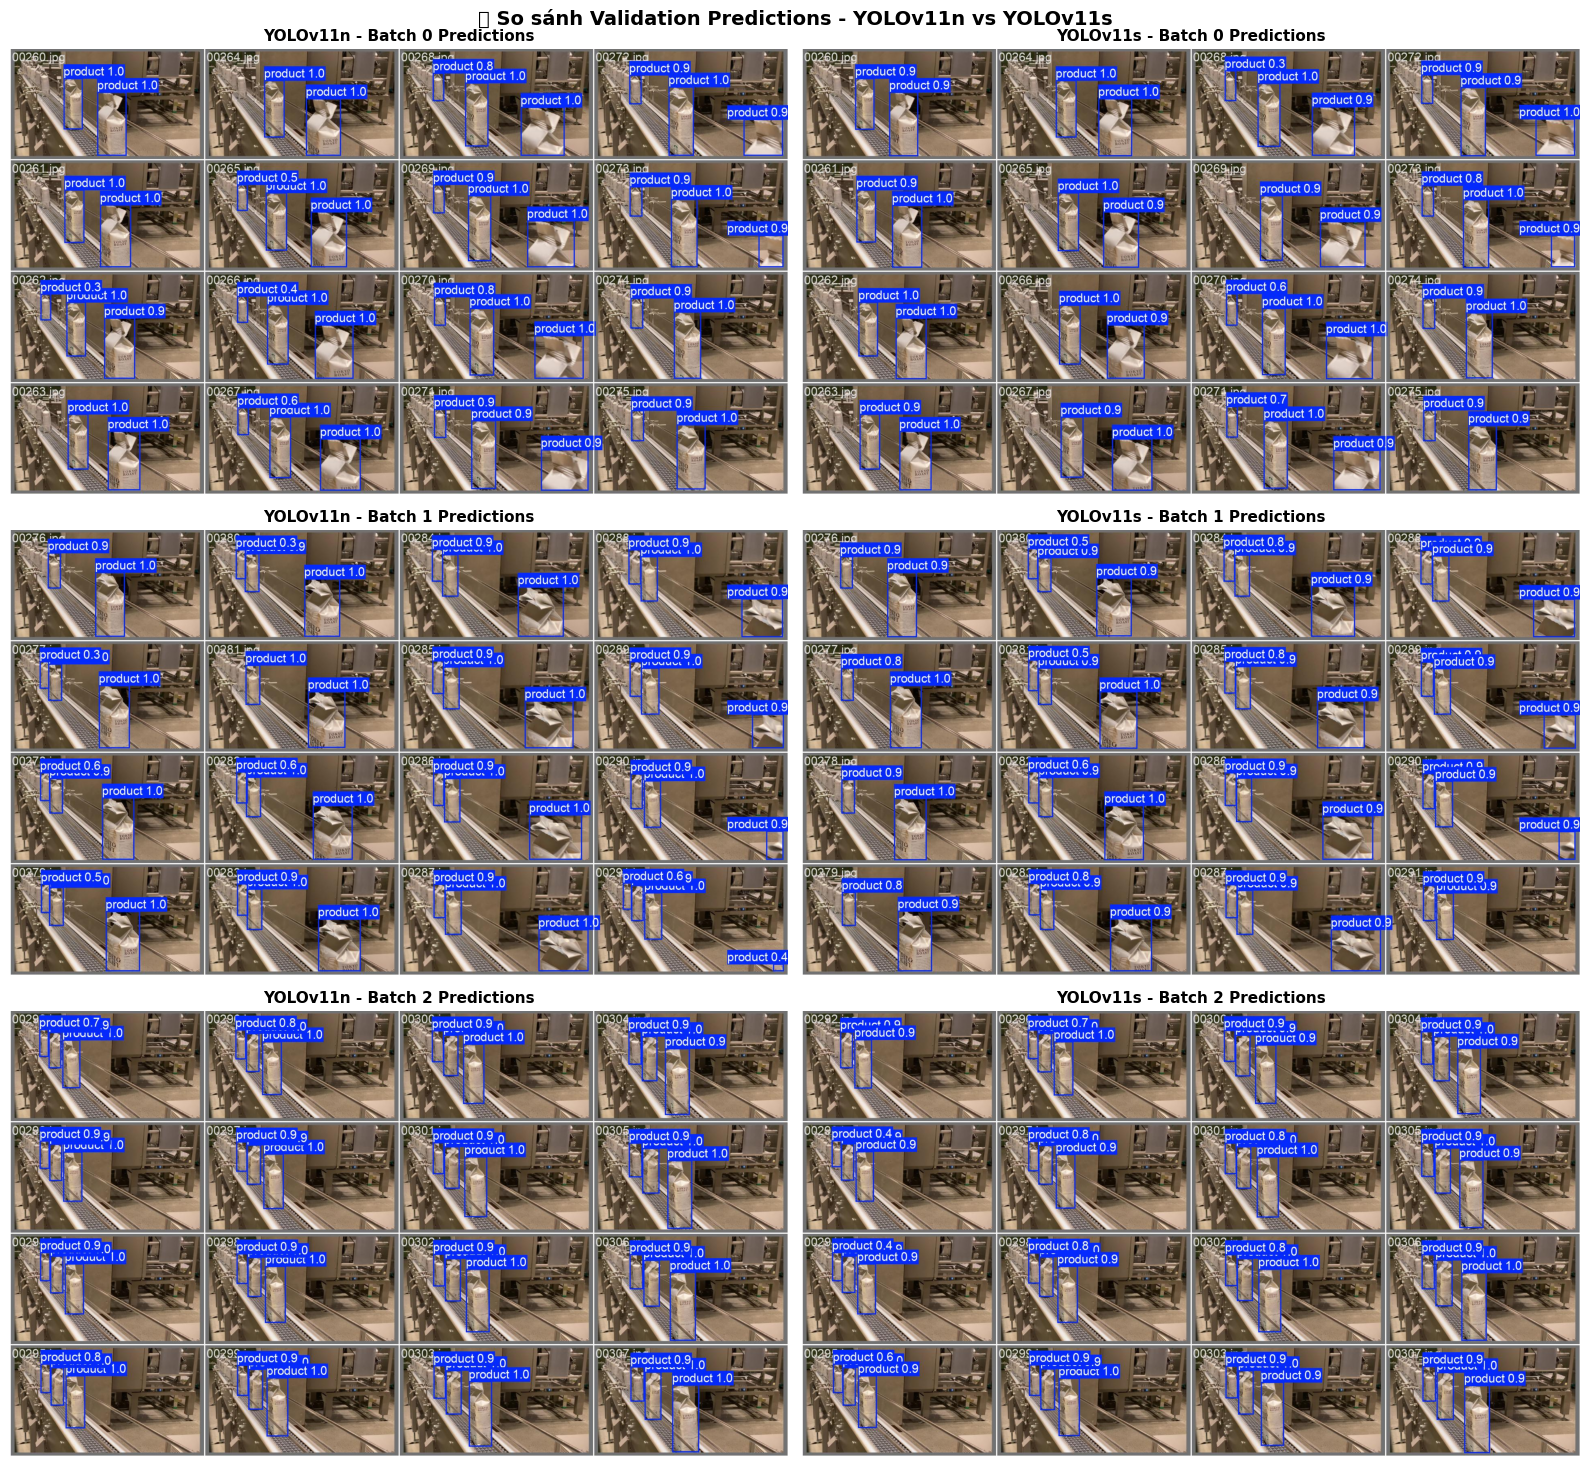

✅ Validation predictions comparison saved


In [29]:
# Hiển thị validation batch predictions từ validation results
fig, axes = plt.subplots(3, 2, figsize=(16, 15))

try:
    # Batch 0 - YOLOv11n
    nano_batch0_pred = Image.open(f'{VAL_NANO_PATH}/val_batch0_pred.jpg')
    axes[0, 0].imshow(nano_batch0_pred)
    axes[0, 0].set_title('YOLOv11n - Batch 0 Predictions', fontsize=11, fontweight='bold')
    axes[0, 0].axis('off')

    # Batch 0 - YOLOv11s
    small_batch0_pred = Image.open(f'{VAL_SMALL_PATH}/val_batch0_pred.jpg')
    axes[0, 1].imshow(small_batch0_pred)
    axes[0, 1].set_title('YOLOv11s - Batch 0 Predictions', fontsize=11, fontweight='bold')
    axes[0, 1].axis('off')

    # Batch 1 - YOLOv11n
    nano_batch1_pred = Image.open(f'{VAL_NANO_PATH}/val_batch1_pred.jpg')
    axes[1, 0].imshow(nano_batch1_pred)
    axes[1, 0].set_title('YOLOv11n - Batch 1 Predictions', fontsize=11, fontweight='bold')
    axes[1, 0].axis('off')

    # Batch 1 - YOLOv11s
    small_batch1_pred = Image.open(f'{VAL_SMALL_PATH}/val_batch1_pred.jpg')
    axes[1, 1].imshow(small_batch1_pred)
    axes[1, 1].set_title('YOLOv11s - Batch 1 Predictions', fontsize=11, fontweight='bold')
    axes[1, 1].axis('off')

    # Batch 2 - YOLOv11n
    nano_batch2_pred = Image.open(f'{VAL_NANO_PATH}/val_batch2_pred.jpg')
    axes[2, 0].imshow(nano_batch2_pred)
    axes[2, 0].set_title('YOLOv11n - Batch 2 Predictions', fontsize=11, fontweight='bold')
    axes[2, 0].axis('off')

    # Batch 2 - YOLOv11s
    small_batch2_pred = Image.open(f'{VAL_SMALL_PATH}/val_batch2_pred.jpg')
    axes[2, 1].imshow(small_batch2_pred)
    axes[2, 1].set_title('YOLOv11s - Batch 2 Predictions', fontsize=11, fontweight='bold')
    axes[2, 1].axis('off')

    plt.suptitle('🔍 So sánh Validation Predictions - YOLOv11n vs YOLOv11s', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{PROJECT_NAME}/validation_predictions_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Validation predictions comparison saved")
except Exception as e:
    print(f"⚠️ Không thể load validation batch images: {e}")

## 8. Xuất Model và Lưu kết quả

In [30]:
# Xuất model sang các định dạng khác (ONNX, TensorRT, etc.)
print("📦 Xuất model YOLOv11n sang ONNX...")
best_nano.export(format='onnx')

print("\n📦 Xuất model YOLOv11s sang ONNX...")
best_small.export(format='onnx')

print("\n✅ Xuất model hoàn tất!")

📦 Xuất model YOLOv11n sang ONNX...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'yolo_industrial_product/yolov11n/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 169ms
Prepared 6 packages in 8.22s
Installed 6 packages in 276ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.19.1
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.77

requirements: AutoUpdate success ✅ 9.4s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.1 opset 22...
ONN

In [31]:
# Lưu báo cáo so sánh
report = f"""
================================================================================
                    BÁO CÁO SO SÁNH YOLOV11n vs YOLOv11s
                    Industrial Product Detection
================================================================================

📊 METRICS COMPARISON:
-----------------------
| Model     | mAP50   | mAP50-95 | Precision | Recall  |
|-----------|---------|----------|-----------|---------|
| YOLOv11n  | {metrics_nano.box.map50:.4f}  | {metrics_nano.box.map:.4f}   | {metrics_nano.box.mp:.4f}    | {metrics_nano.box.mr:.4f}  |
| YOLOv11s  | {metrics_small.box.map50:.4f}  | {metrics_small.box.map:.4f}   | {metrics_small.box.mp:.4f}    | {metrics_small.box.mr:.4f}  |

⚡ INFERENCE SPEED:
-------------------
- YOLOv11n: {nano_speed:.2f} ms/image
- YOLOv11s: {small_speed:.2f} ms/image

📁 MODEL FILES:
---------------
- YOLOv11n best: {PROJECT_NAME}/yolov11n/weights/best.pt
- YOLOv11s best: {PROJECT_NAME}/yolov11s/weights/best.pt

🔧 TRAINING CONFIGURATION:
--------------------------
- Epochs: {EPOCHS}
- Batch size: {BATCH_SIZE}
- Image size: {IMG_SIZE}
- Early stopping patience: {PATIENCE}

📅 Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
================================================================================
"""

# Lưu báo cáo
with open(f'{PROJECT_NAME}/comparison_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print(report)
print(f"\n💾 Báo cáo đã được lưu tại: {PROJECT_NAME}/comparison_report.txt")


                    BÁO CÁO SO SÁNH YOLOV11n vs YOLOv11s
                    Industrial Product Detection

📊 METRICS COMPARISON:
-----------------------
| Model     | mAP50   | mAP50-95 | Precision | Recall  |
|-----------|---------|----------|-----------|---------|
| YOLOv11n  | 0.9888  | 0.9527   | 0.9331    | 0.9647  |
| YOLOv11s  | 0.9816  | 0.9501   | 0.9605    | 0.9529  |

⚡ INFERENCE SPEED:
-------------------
- YOLOv11n: 47.48 ms/image
- YOLOv11s: 25.82 ms/image

📁 MODEL FILES:
---------------
- YOLOv11n best: yolo_industrial_product/yolov11n/weights/best.pt
- YOLOv11s best: yolo_industrial_product/yolov11s/weights/best.pt

🔧 TRAINING CONFIGURATION:
--------------------------
- Epochs: 100
- Batch size: 16
- Image size: 640
- Early stopping patience: 20

📅 Generated: 2025-12-01 05:35:47


💾 Báo cáo đã được lưu tại: yolo_industrial_product/comparison_report.txt


In [32]:
# Download kết quả về máy local (tùy chọn)
# Nén toàn bộ kết quả training
!zip -r training_results.zip {PROJECT_NAME}/

# Download file zip
from google.colab import files
files.download('training_results.zip')

print("\n🎉 Hoàn tất! Bạn có thể download file training_results.zip về máy.")

  adding: yolo_industrial_product/ (stored 0%)
  adding: yolo_industrial_product/f1_curve_comparison.png (deflated 11%)
  adding: yolo_industrial_product/comparison_chart.png (deflated 23%)
  adding: yolo_industrial_product/validation_predictions_comparison.png (deflated 1%)
  adding: yolo_industrial_product/yolov11n/ (stored 0%)
  adding: yolo_industrial_product/yolov11n/labels.jpg (deflated 42%)
  adding: yolo_industrial_product/yolov11n/BoxF1_curve.png (deflated 17%)
  adding: yolo_industrial_product/yolov11n/val_batch1_labels.jpg (deflated 6%)
  adding: yolo_industrial_product/yolov11n/val_batch0_pred.jpg (deflated 6%)
  adding: yolo_industrial_product/yolov11n/val_batch2_labels.jpg (deflated 14%)
  adding: yolo_industrial_product/yolov11n/train_batch1.jpg (deflated 5%)
  adding: yolo_industrial_product/yolov11n/BoxR_curve.png (deflated 18%)
  adding: yolo_industrial_product/yolov11n/train_batch2.jpg (deflated 4%)
  adding: yolo_industrial_product/yolov11n/val_batch0_labels.jpg (de

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎉 Hoàn tất! Bạn có thể download file training_results.zip về máy.


In [33]:
# Đẩy kết quả training lên Google Drive
from google.colab import drive
import shutil
import os

# Mount Google Drive
print("📁 Mounting Google Drive...")
drive.mount('/content/gdrive')

# Định nghĩa đường dẫn
zip_file = 'training_results.zip'
gdrive_path = '/content/gdrive/MyDrive'
target_dir = f'{gdrive_path}/SAM2_YOLO'

# Tạo folder nếu chưa tồn tại
os.makedirs(target_dir, exist_ok=True)

# Copy file zip lên Google Drive
print(f"📤 Uploading {zip_file} to Google Drive...")
try:
    shutil.copy(zip_file, target_dir)
    print(f"✅ File đã được lưu tại: {target_dir}/{zip_file}")
except Exception as e:
    print(f"❌ Lỗi khi upload: {e}")

# Copy toàn bộ folder training results
print(f"\n📤 Uploading {PROJECT_NAME} folder to Google Drive...")
try:
    target_folder = f'{target_dir}/{PROJECT_NAME}'
    if os.path.exists(target_folder):
        shutil.rmtree(target_folder)
    shutil.copytree(PROJECT_NAME, target_folder)
    print(f"✅ Folder đã được lưu tại: {target_folder}")
except Exception as e:
    print(f"❌ Lỗi khi upload folder: {e}")

print("\n🎉 Upload hoàn tất!")
print(f"📍 Google Drive path: {target_dir}")

📁 Mounting Google Drive...
Mounted at /content/gdrive
📤 Uploading training_results.zip to Google Drive...
✅ File đã được lưu tại: /content/gdrive/MyDrive/SAM2_YOLO/training_results.zip

📤 Uploading yolo_industrial_product folder to Google Drive...
✅ Folder đã được lưu tại: /content/gdrive/MyDrive/SAM2_YOLO/yolo_industrial_product

🎉 Upload hoàn tất!
📍 Google Drive path: /content/gdrive/MyDrive/SAM2_YOLO


## 📝 Tóm tắt

### Các file output quan trọng:
- **Model weights**: `yolo_industrial_product/yolov11n/weights/best.pt` và `yolo_industrial_product/yolov11s/weights/best.pt`
- **Training curves**: `yolo_industrial_product/*/results.csv`
- **Confusion matrix**: `yolo_industrial_product/*/confusion_matrix.png`
- **Báo cáo so sánh**: `yolo_industrial_product/comparison_report.txt`

### Khuyến nghị:
- **YOLOv11n**: Phù hợp cho ứng dụng cần tốc độ cao, thiết bị có tài nguyên hạn chế (mobile, edge devices)
- **YOLOv11s**: Cân bằng giữa tốc độ và độ chính xác, phù hợp cho hầu hết các ứng dụng

### Bước tiếp theo:
1. So sánh metrics để chọn model phù hợp
2. Sử dụng model đã train để inference trên video/ảnh mới
3. Fine-tune thêm nếu cần cải thiện độ chính xác